In [1]:
#Toggle saving the figures
save = True

#Numerical tolerance on NOONs for removing them from the calculation
ncut = 10**-12

#Number of Sinkhorn iterations to do before starting Fermionic Sinkhorn
pre_iters = 10

#Try to import bfsinkhorn, if it's not installed, try to import it from the cloned directory
try:
    import bfsinkhorn
except ModuleNotFoundError:
    import sys
    sys.path.append('..')
    import bfsinkhorn

#Import numpy
import numpy as np

#Import jax and set floats to 64-bit
from jax.config import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)

#Import the Fermionic Sinkhorn
from bfsinkhorn.fermion import sinkhorn

#Import for plotting and making plots look good
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
plt.style.use(['seaborn-paper', 'seaborn-dark-palette'])
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='sans-serif')
plt.rc('lines', markersize=8)
single_column = 3 + 3/8

# Figure 3: synthetic fermion distribution

Construct a fermionic distribution of occupation numbers, with $N$ heavily occupied NOs and the remaining weakly occupied. The decay is linear in the index of the occupation number.


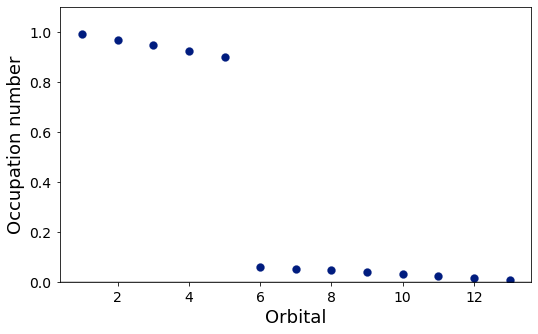

In [2]:
norb = 13
N = 5
n1 = 0.99
nN = 0.9
delta = 0.84
nlast = ((-2 + delta + n1)*N + (-delta + nN)*norb)/(N - norb)
beta = 1.
if nlast < 0.:
    print('last n is below zero')
n = np.empty(norb)
n[:N] = n1 - (n1-nN)/(N-1)*np.arange(N)
sum_to_N = np.sum(n[:N])
n[N:] = nN - delta + np.arange(norb-N)*(N*(2 - 2*delta - n1 + nN) + 2*(delta - nN)*norb)/((N - norb)*(1 + N - norb))
    
plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))
plt.scatter(np.arange(norb)+1, n)
plt.xlabel('Orbital')
plt.ylabel('Occupation number')
plt.ylim(0, 1.1)
plt.axhline(y=0, color='0', linestyle='-')
plt.show()

Run both the fermionic and regular ('old') Sinkhorn.

In [3]:
print('Running Fermionic Sinkhorn')
result = sinkhorn(n, N)
print('Running regular Sinkhorn')
result_old = sinkhorn(n, N, old=True, max_iters=100)

Running Fermionic Sinkhorn
iter 0, error 0.3887858550531057
iter 1, error 0.7404605224445713
iter 2, error 0.2534337192836601
iter 3, error 0.3129135850901906
iter 4, error 0.15662659522392108
iter 5, error 0.15484796475839813
iter 6, error 0.09311268671935648
iter 7, error 0.0814119431919344
iter 8, error 0.0539668688184136
iter 9, error 0.04404280550961001
iter 10, error 0.030795040690874256
iter 11, error 0.02417790848602598
iter 12, error 0.017411771432667034
iter 13, error 0.013376847875142529
iter 14, error 0.009792746612441477
iter 15, error 0.0074325226832991295
iter 16, error 0.005491081906617816
iter 17, error 0.004139390820471905
iter 18, error 0.003073783389312957
iter 19, error 0.002308345186186677
iter 20, error 0.001718992599171642
iter 21, error 0.001288186779913332
iter 22, error 0.0009608209125001148
iter 23, error 0.0007191703357631134
iter 24, error 0.000536884541714815
iter 25, error 0.00040158938317377303
iter 26, error 0.0002999484825064666
iter 27, error 0.00022

Fermionic Sinkhorn first lingers behind Sinkhorn, but then converges well. Make a nice plot to show this. 

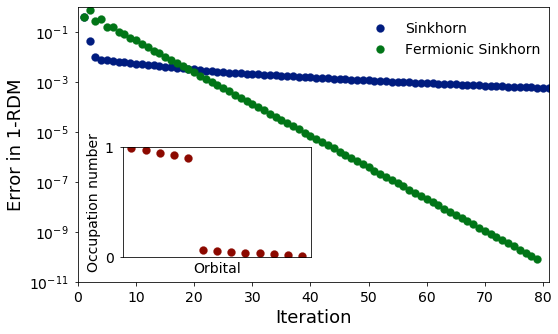

In [4]:
single_column = 3 + 3/8

fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.yscale('log')
plt.scatter(np.arange(len(result_old['errors']))+1, result_old['errors'], label='Sinkhorn')
plt.scatter(np.arange(len(result['errors']))+1, result['errors'], label='Fermionic Sinkhorn')
plt.legend(loc=(0.6, 0.8), framealpha=0)
plt.xlabel('Iteration')
plt.ylabel('Error in 1-RDM')
plt.ylim(10**-11, 1)
plt.xlim(0, 81)
ax = fig.get_axes()[0]
axins = inset_axes(ax, width="40%", height="40%", loc=3, bbox_to_anchor=(0.08,0.065,1,1), bbox_transform=ax.transAxes)
plt.scatter(np.arange(norb)+1, n, color='C2')
plt.xlabel('Orbital', fontsize=SMALL_SIZE)
plt.ylabel('Occupation number', fontsize=SMALL_SIZE)
plt.xticks([])
plt.yticks([0, 1])
plt.ylim(0, 1)
plt.savefig('fig3_fermion_convergence.pdf',
            bbox_inches='tight', 
            transparent=True,
            pad_inches=0.1)
plt.show()

# Supplementary figure 3: hotstart Fermionic Sinkhorn

Show what happens if we start instead from a Sinkhorn starting point run for 10 iterations.

Running Sinkhorn for hotstart
iter 0, error 0.3887858550531057
iter 1, error 0.04009271645901086
iter 2, error 0.009850258029487321
iter 3, error 0.007593240605372522
iter 4, error 0.00701956499178622
iter 5, error 0.006600700129469891
iter 6, error 0.00622240282490758
iter 7, error 0.0058703113755051335
iter 8, error 0.005541289661529664
iter 9, error 0.005233567510712359
iter 10, error 0.004945634681576189
Running Fermionic Sinkhorn
iter 0, error 0.004945634681575745
iter 1, error 0.0002198050222684579
iter 2, error 8.816899313172227e-05
iter 3, error 6.576325887641156e-05
iter 4, error 4.913884204384156e-05
iter 5, error 3.6727569276129995e-05
iter 6, error 2.7447574205027164e-05
iter 7, error 2.051442879504213e-05
iter 8, error 1.5331418714698702e-05
iter 9, error 1.1458548607597499e-05
iter 10, error 8.563646072361902e-06
iter 11, error 6.400315518554148e-06
iter 12, error 4.783368955560072e-06
iter 13, error 3.5749839970670994e-06
iter 14, error 2.6718295010729615e-06
iter 15, er

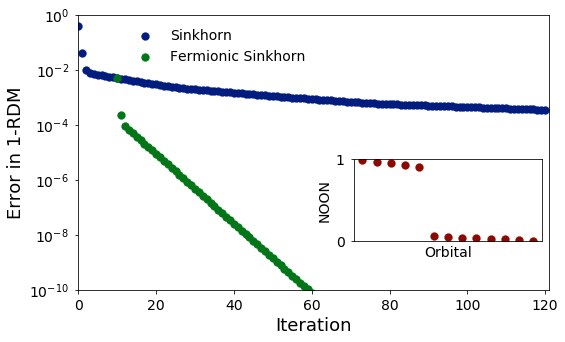

In [5]:
max_iters = 120

print('Running Sinkhorn for hotstart')
result_start = sinkhorn(n, N, old=True, max_iters=pre_iters)
print('Running Fermionic Sinkhorn')
result = sinkhorn(n, N, eps=result_start['eps'], max_iters=max_iters-pre_iters)
print('Running Sinkhorn')
result_old = sinkhorn(n, N, old=True, max_iters=max_iters)


fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.yscale('log')
plt.scatter(np.arange(len(result_old['errors'])), result_old['errors'], label='Sinkhorn')
plt.scatter(np.arange(len(result['errors']))+pre_iters, result['errors'], label='Fermionic Sinkhorn')
plt.legend(loc=(0.1, 0.8), framealpha=0)
plt.xlabel('Iteration')
plt.ylabel('Error in 1-RDM')
plt.ylim(10**-10, 1)
plt.xlim(0, max_iters+1)
ax = fig.get_axes()[0]
axins = inset_axes(ax, width="40%", height="30%", loc=3, bbox_to_anchor=(0.57,0.15,1,1), bbox_transform=ax.transAxes)
plt.scatter(np.arange(norb)+1, n, color='C2')
plt.xlabel('Orbital', fontsize=SMALL_SIZE)
plt.ylabel('NOON', fontsize=SMALL_SIZE)
plt.xticks([])
plt.yticks([0, 1])
plt.ylim(0, 1)
if save:
    plt.savefig('Sfig3_fermion_convergence_hotstart.pdf',
                bbox_inches='tight', 
                transparent=True,
                pad_inches=0.1)
plt.show()

Now switch to modelling zero-temperature occupation numbers with a non-interacting canonical ensemble. We use `pyscf` for the ground-state calculations.

In [6]:
from pyscf import gto, scf, cc

# Figure 4: H2O at equilibrium geometry
First run a CCSD calculation in a cc-pVQZ basis.

In [7]:
mol = gto.M(atom='''O 0.0000000 0.0000000 0.1172700; 
H 0.0000000 0.7569520 -0.4690790;
H 0.0000000 -0.7569520 -0.4690790''', basis='cc-pVQZ')
mf = scf.RHF(mol)
mf.kernel()
ccsd = cc.CCSD(mf).run()

converged SCF energy = -76.0648123418003
E(CCSD) = -76.38183505204877  E_corr = -0.3170227102484837


In [8]:
max_iters = 500
n, U = jnp.linalg.eigh(ccsd.make_rdm1())
N = sum(mol.nelec)//2
n = jnp.flip(n)/2
n = n[np.where(n > ncut)]
n = n/np.sum(n)*N

norb = n.size
result_start = sinkhorn(n, N, old=True, max_iters=pre_iters, verbose=False)
result = sinkhorn(n, N, eps=result_start['eps'], max_iters=max_iters-pre_iters, verbose=False)
result_old = sinkhorn(n, N, old=True, max_iters=max_iters, verbose=False)

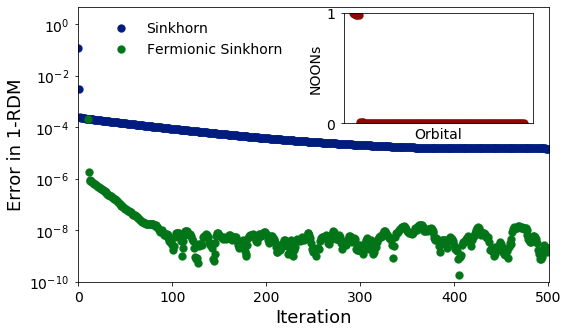

In [9]:
single_column = 3 + 3/8

fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.yscale('log')
plt.scatter(np.arange(len(result_old['errors'])), result_old['errors'], label='Sinkhorn')
plt.scatter(np.arange(len(result['errors']))+pre_iters, result['errors'], label='Fermionic Sinkhorn')

plt.legend(loc=(0.05, 0.8), framealpha=0)
plt.xlabel('Iteration')
plt.ylabel('Error in 1-RDM')
plt.ylim(10**-10, 5)
plt.xlim(0, max_iters+1)
ax = fig.get_axes()[0]
axins = inset_axes(ax, width="40%", height="40%", loc=3, bbox_to_anchor=(0.55,0.55,1,1), bbox_transform=ax.transAxes)
plt.scatter(np.arange(norb)+1, n, color='C2')
plt.xlabel('Orbital', fontsize=SMALL_SIZE)
plt.ylabel('NOONs', fontsize=SMALL_SIZE)
plt.xticks([])
plt.yticks([0, 1])
plt.ylim(0, 1)
plt.savefig('fig4_H2O_convergence.pdf',
             bbox_inches='tight', 
             transparent=True,
             pad_inches=0.1)
plt.show()